In [32]:
%matplotlib inline
import os
import sys
import json
import spotipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier

from spotirecs import get_playlist_tracks, get_features, Playlists
from spotirecs.plotting import plot_features

# pandas settings
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', False)

In [33]:
def dict_to_json(data: dict, path: str):
    with open(path, "w", encoding="utf-8") as outfile:
        json.dump(data, outfile)

In [34]:
username_id = '113586775'

playlist_of_interest_name = 'Favorites'

## Initialization

In [35]:
# Logging in

spotify = spotipy.Spotify(requests_timeout=10, client_credentials_manager=SpotifyClientCredentials())

# Which playlists do I have?
playlists: Playlists | None = spotify.user_playlists(username_id)
if playlists is None:
    print("Playlists could not be retrieved")
    sys.exit(1)

playlist_of_interest = None

playlists_of_no_interest = []
for playlist in playlists['items']:
    if playlist['name'] == playlist_of_interest_name:
        playlist_of_interest = playlist
    elif playlist['owner']['id'] == username_id:
        playlists_of_no_interest.append(playlist)


In [36]:
if playlist_of_interest is None:
    print("Given playlist name can not be found")
    sys.exit(1)

good_track_ids, good_track_names = get_playlist_tracks(spotify, playlist_of_interest)

bad_track_ids = []
bad_track_names = []

for playlist in playlists_of_no_interest:
    tmp_ids, tmp_names = get_playlist_tracks(spotify, playlist)
    
    for tmp_id, tmp_name in zip(tmp_ids, tmp_names):
        if tmp_id not in good_track_ids and tmp_id not in bad_track_ids:
            bad_track_ids.append(tmp_id)
            bad_track_names.append(tmp_name)

In [37]:
ratings = [1] * len(good_track_ids) + [0] * len(bad_track_ids)
track_ids = good_track_ids + bad_track_ids
track_names = good_track_names + bad_track_names

## Feature-extraction

In [57]:
data_file = "track_features.csv"

features = get_features(spotify, track_ids)
favorites_df = pd.DataFrame(features, index=track_names)
favorites_df['rating'] = ratings

if os.path.isfile(data_file):
    # If the data file exists, look for new tracks and append their features
    print("Audio features found")
    read_df = pd.read_csv(data_file, index_col=0)
    read_ids = read_df['id']
    
    print("\tFinding new tracks ...")
    tmp_indices = []
    for i, track_id in enumerate(track_ids):
        if track_id not in read_ids.values:
            tmp_indices.append(i)

    new_ids = [track_ids[i] for i in tmp_indices]
    new_names = [track_names[i] for i in tmp_indices]
    new_ratings = [ratings[i] for i in tmp_indices]

    new_features = get_features(spotify, new_ids)
    new_features_df = pd.DataFrame(new_features, index=new_names)
    new_features_df['rating'] = new_ratings
    
    if new_features_df.size > 0:
        print("\tAppending new track features to main file ...")
        new_features_df.to_csv(data_file, mode='a')

        print("\tCreating audio features dataframe ...")
        read_df = pd.concat([read_df, new_features_df])
        favorites_df = read_df[read_df['id'].isin(track_ids)]


favorites_df.to_csv(data_file)

print("Done!")
favorites_df

Audio features found
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
rating                int64
dtype: object
	Finding new tracks ...
0
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href     

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,rating
Citizen/Soldier,0.631,0.822,8,-5.503,1,0.0343,0.01140,0.017000,0.1970,0.4830,96.999,audio_features,3NZr9rsioE182Rv8dqZG6g,spotify:track:3NZr9rsioE18...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,232907,4,1
Waterline - 2010 - Remaster,0.386,0.797,0,-7.230,1,0.0372,0.00189,0.000005,0.0959,0.2300,108.836,audio_features,0ayPGGN1YW9lU7v00uOM5E,spotify:track:0ayPGGN1YW9l...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,273160,4,1
Love Is a Loser's Game - 2010 - Remaster,0.307,0.555,10,-7.354,0,0.0255,0.01410,0.000000,0.0865,0.2650,90.640,audio_features,7oyVUb08xXoOqlvtoI1c8Y,spotify:track:7oyVUb08xXoO...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,227933,4,1
Sweet Child O' Mine,0.435,0.947,6,-4.759,1,0.0489,0.08760,0.072700,0.1130,0.6370,125.133,audio_features,32e5Wq10DT7xYrlRl5qSYF,spotify:track:32e5Wq10DT7x...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,355267,4,1
Paradise City,0.277,0.979,11,-5.578,1,0.0979,0.01830,0.013800,0.1170,0.4510,100.339,audio_features,2bHQrsgmBzX5WF7thpMZrV,spotify:track:2bHQrsgmBzX5...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,406200,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.172,0.228,2,-17.281,0,0.0397,0.62200,0.945000,0.0705,0.0339,129.148,audio_features,2V3hP9u4jI9I9ftHrgZ0MF,spotify:track:2V3hP9u4jI9I...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,320467,3,0
Brass Buttons,0.161,0.345,9,-16.228,0,0.0435,0.13100,0.853000,0.1890,0.0603,94.033,audio_features,5kHSrLEGsoOTfazEKvVliP,spotify:track:5kHSrLEGsoOT...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,457107,4,0
Out Of The Frying-Pan,0.358,0.536,9,-12.392,1,0.0372,0.18100,0.904000,0.1930,0.1990,89.793,audio_features,608UmlS8Q8Kp3EztDD2SUI,spotify:track:608UmlS8Q8Kp...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,353440,4,0
A Good Omen,0.173,0.388,0,-15.277,1,0.0366,0.03810,0.909000,0.1710,0.0491,112.089,audio_features,2wcmpZsg0O4R0xNeUPZ50o,spotify:track:2wcmpZsg0O4R...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,344747,4,0


## Pre-processing

In [39]:
training_df = favorites_df[["acousticness", "danceability", "duration_ms", "energy", "instrumentalness",  "key", "liveness", "loudness", "mode", "speechiness", "tempo", "valence", "rating"]]
training_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,rating
Citizen/Soldier,0.01140,0.631,232907,0.822,0.017000,8,0.1970,-5.503,1,0.0343,96.999,0.4830,1
Waterline - 2010 - Remaster,0.00189,0.386,273160,0.797,0.000005,0,0.0959,-7.230,1,0.0372,108.836,0.2300,1
Love Is a Loser's Game - 2010 - Remaster,0.01410,0.307,227933,0.555,0.000000,10,0.0865,-7.354,0,0.0255,90.640,0.2650,1
Sweet Child O' Mine,0.08760,0.435,355267,0.947,0.072700,6,0.1130,-4.759,1,0.0489,125.133,0.6370,1
Paradise City,0.01830,0.277,406200,0.979,0.013800,11,0.1170,-5.578,1,0.0979,100.339,0.4510,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Riddles In The Dark,0.62200,0.172,320467,0.228,0.945000,2,0.0705,-17.281,0,0.0397,129.148,0.0339,0
Brass Buttons,0.13100,0.161,457107,0.345,0.853000,9,0.1890,-16.228,0,0.0435,94.033,0.0603,0
Out Of The Frying-Pan,0.18100,0.358,353440,0.536,0.904000,9,0.1930,-12.392,1,0.0372,89.793,0.1990,0
A Good Omen,0.03810,0.173,344747,0.388,0.909000,0,0.1710,-15.277,1,0.0366,112.089,0.0491,0


In [41]:
column_names = training_df.columns[:-1]

d=training_df.dtypes
print(d)
# fig, axes = plt.subplots(
#     len(column_names), len(column_names), figsize=(len(column_names) * 2, len(column_names) * 2)
# )
# for i, col_i in enumerate(column_names):
#     for j, col_j in enumerate(column_names):
#         axis: plt.Axes = axes[j, i]  # type: ignore
#         axis.scatter(
#             training_df.loc[training_df['rating'] == 1][col_j],
#             training_df.loc[training_df['rating'] == 1][col_i],
#             s=1, c='tab:blue'
#         )
#         axis.scatter(
#             training_df.loc[training_df['rating'] == 0][col_j],
#             training_df.loc[training_df['rating'] == 0][col_i],
#             s=1, c='tab:orange'
#         )
#         axis.set_xticks([])
#         axis.set_xticklabels([])
#         axis.set_yticks([])
#         axis.set_yticklabels([])
#         if i == 0:
#             axis.set_ylabel(col_j)
#         if j == 0:
#             axis.set_xlabel(col_i)
#             axis.xaxis.set_label_position('top')

# fig, _ = plot_features(column_names, training_df)

acousticness        float64
danceability        float64
duration_ms           int64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
valence             float64
rating                int64
dtype: object


Number of components for 95% variance: 10


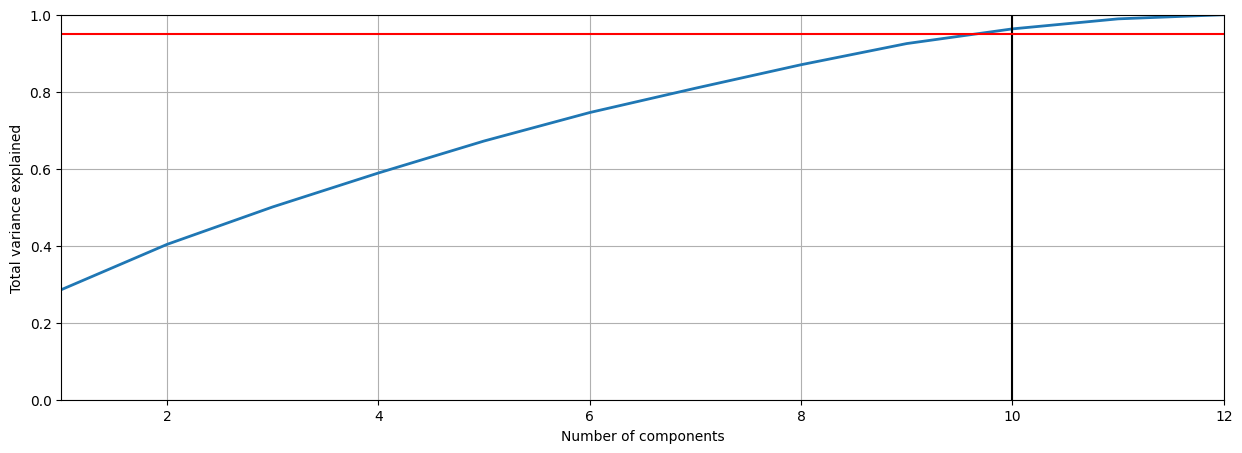

In [ ]:
X_train = training_df.drop('rating', axis=1)
y_train = training_df['rating']

X_scaled = StandardScaler().fit_transform(X_train)
pca = decomposition.PCA().fit(X_scaled)

variance_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(variance_ratio)
threshold = 0.95
n_components = next(i for i, v in enumerate(cum_var) if v > threshold) + 1
print(f"Number of components for {threshold*100:.0f}% variance: {n_components}")

plt.figure(figsize=(15,5))
plt.plot(range(1,13), cum_var, lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total variance explained')
plt.xlim(1, 12)
plt.ylim(0, 1)
plt.grid()
plt.axvline(n_components, c='k')
plt.axhline(threshold, c='r')


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

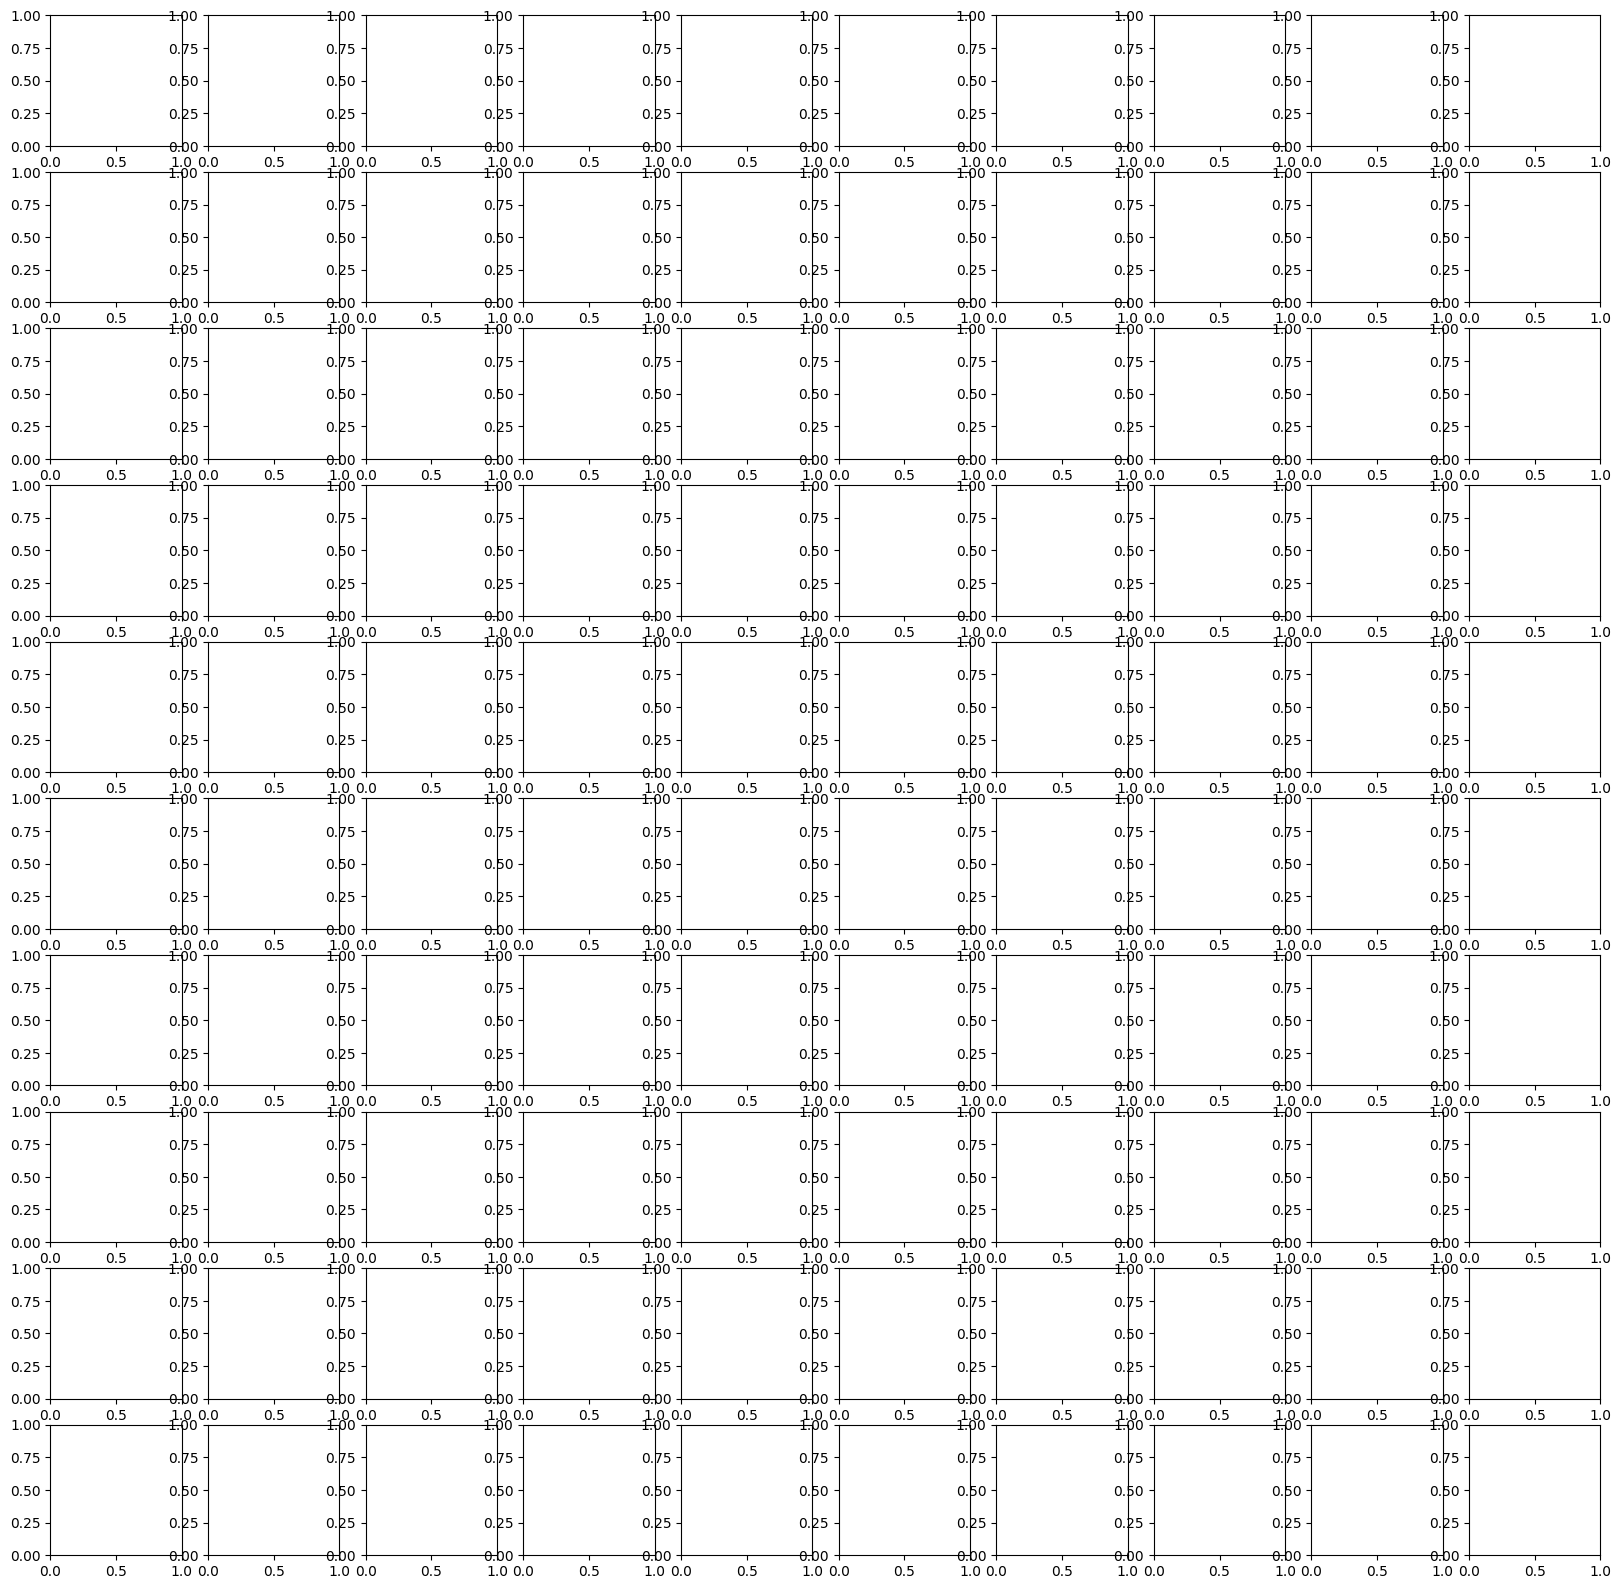

In [ ]:
# Fit your dataset to the optimal pca
pca = decomposition.PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_scaled)

column_names = [f"Component #{i + 1}" for i in range(n_components)]

plot_features(column_names, X_train_pca)

# fig, axes = plt.subplots(n_components, n_components, figsize=(n_components*2, n_components*2))
# for i in range(n_components):
#     for j in range(n_components):
#         ax = axes[j, i]
#         ax.scatter(X_train_pca[y_train == 1][:, i], X_train_pca[y_train == 1][:, j], c='tab:blue', s=1)
#         ax.scatter(X_train_pca[y_train == 0][:, i], X_train_pca[y_train == 0][:, j], c='tab:orange', s=1)
#         ax.set_xticks([])
#         ax.set_xticklabels([])
#         ax.set_yticks([])
#         ax.set_yticklabels([])
#         if i == 0:
#             ax.set_ylabel(f"Component #{j + 1}")
#         if j == 0:
#             ax.set_xlabel(f"Component #{i + 1}")
#             ax.xaxis.set_label_position('top') 
# plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
v = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 6), max_features=10000)
X_names_sparse = v.fit_transform(track_names)
X_names_sparse.shape

X_train = sparse.csr_matrix(sparse.hstack([X_train_pca, X_names_sparse]))
X_train.shape

(1935, 10010)

## Training

In [ ]:
# K-nearest neighbor classification
n_splits = 5
max_neighbors = 50

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

knc_params = {'n_neighbors': range(1, max_neighbors + 1)}
knc = KNeighborsClassifier(n_jobs=-1)

knc_grid = GridSearchCV(knc, knc_params, n_jobs=-1, cv=skf, verbose=1)
knc_grid.fit(X_train, y_train)
print("Best score: ", knc_grid.best_score_)

grid_results = pd.DataFrame(knc_grid.cv_results_)
grid_results

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best score:  0.7400516795865633


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003538,0.001159,0.993223,0.234109,1,{'n_neighbors': 1},0.638243,0.726098,0.705426,0.702842,0.669251,0.688372,0.030991,49
1,0.003274,0.000586,0.728007,0.042239,2,{'n_neighbors': 2},0.633075,0.669251,0.661499,0.666667,0.614987,0.649096,0.021396,50
2,0.003602,0.002588,0.754154,0.103031,3,{'n_neighbors': 3},0.682171,0.744186,0.710594,0.713178,0.702842,0.710594,0.020015,47
3,0.004071,0.001544,0.706542,0.058919,4,{'n_neighbors': 4},0.669251,0.720930,0.702842,0.697674,0.671835,0.692506,0.019543,48
4,0.003896,0.001716,0.889725,0.100613,5,{'n_neighbors': 5},0.697674,0.751938,0.726098,0.720930,0.726098,0.724548,0.017264,45
5,0.004483,0.004572,0.835537,0.153560,6,{'n_neighbors': 6},0.702842,0.751938,0.736434,0.723514,0.695090,0.721964,0.020967,46
6,0.003041,0.001195,0.740609,0.091107,7,{'n_neighbors': 7},0.705426,0.770026,0.744186,0.720930,0.720930,0.732300,0.022562,20
7,0.002647,0.001238,0.864708,0.096357,8,{'n_neighbors': 8},0.700258,0.764858,0.754522,0.713178,0.708010,0.728165,0.026270,41
8,0.003933,0.002762,0.883029,0.178766,9,{'n_neighbors': 9},0.723514,0.749354,0.757106,0.731266,0.739018,0.740052,0.012076,1
9,0.004104,0.001530,0.766459,0.064616,10,{'n_neighbors': 10},0.718346,0.764858,0.746770,0.728682,0.720930,0.735917,0.017556,7


(0.0, 50.0)

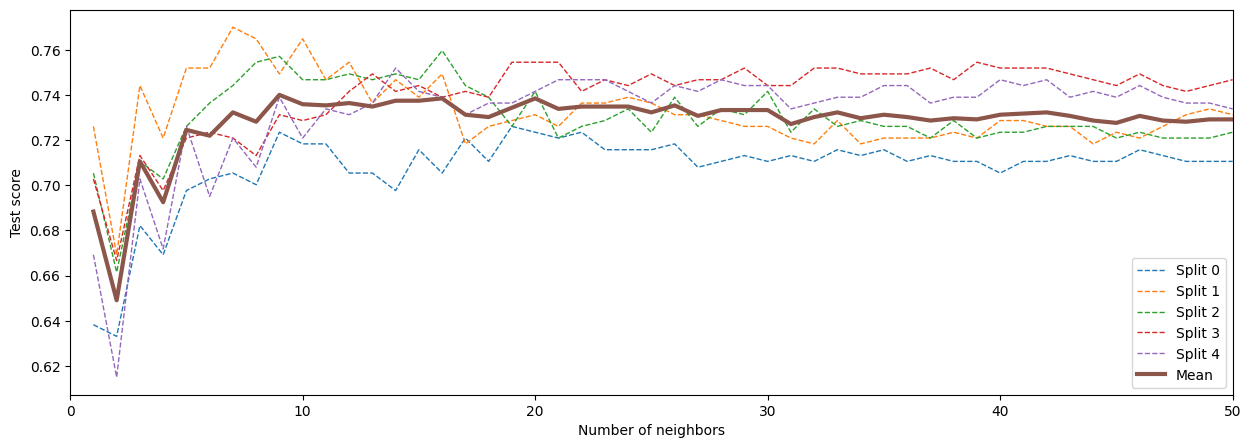

In [ ]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results['param_n_neighbors'], grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['param_n_neighbors'], grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Test score')
plt.xlim(0, max_neighbors)

In [ ]:
# Random Forest classification

rfc_parameters = {
    'max_features': [4, 6, 8, 10], 
    'min_samples_leaf': [1, 3, 5, 7],
    'max_depth': [3, 5, 7]
}
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True)
forest_grid = GridSearchCV(rfc, rfc_parameters, n_jobs=-1, cv=skf, verbose=1)
forest_grid.fit(X_train, y_train)
print("Best score: ", forest_grid.best_score_)

grid_results = pd.DataFrame(forest_grid.cv_results_)
grid_results

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score:  0.6294573643410852


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.978264,0.153797,0.077494,0.021852,3,4,1,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8
1,0.938921,0.190884,0.116846,0.057187,3,4,3,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8
2,0.676890,0.067014,0.067649,0.034855,3,4,5,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8
3,0.618124,0.025357,0.049687,0.006837,3,4,7,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8
4,0.603568,0.029733,0.050957,0.018028,3,6,1,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8
5,0.587146,0.040815,0.041077,0.003649,3,6,3,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8
6,0.596802,0.040370,0.045018,0.007742,3,6,5,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8
7,0.604217,0.043925,0.048544,0.010605,3,6,7,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8
8,0.610361,0.038822,0.043162,0.004763,3,8,1,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8
9,0.595227,0.048686,0.050233,0.009358,3,8,3,"{'max_depth': 3, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,8


([], [])

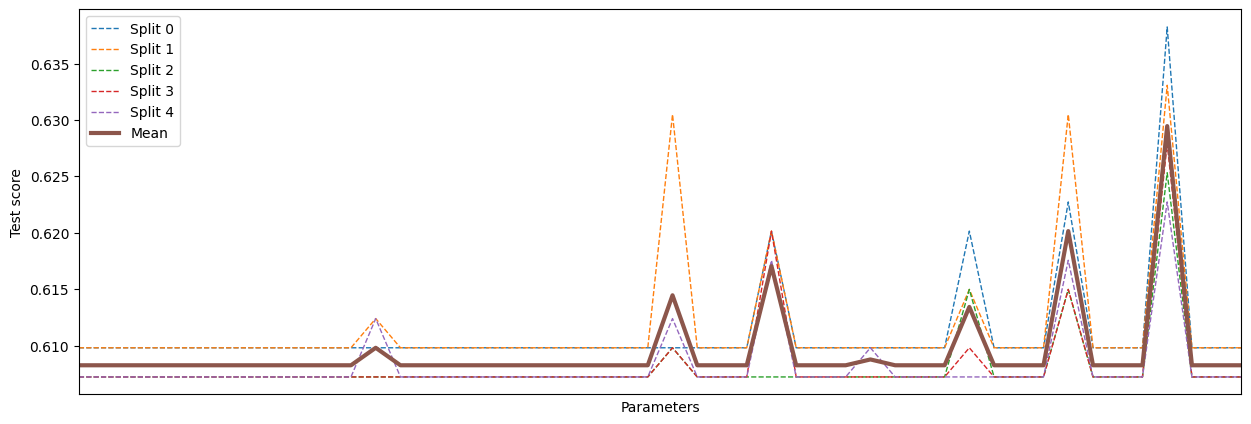

In [ ]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

In [ ]:
# Decision tree classification

tree_parameters = {
    'max_depth': range(1,11),
    'max_features': range(4, 11)
}
tree = DecisionTreeClassifier()
tree_grid = GridSearchCV(tree, tree_parameters, cv=skf, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)
print("Best score: ", tree_grid.best_score_)

grid_results = pd.DataFrame(tree_grid.cv_results_)
grid_results

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best score:  0.6242894056847546


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006819,0.001586,0.003432,0.001904,1,4,"{'max_depth': 1, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,69
1,0.005542,0.002074,0.002550,0.000512,1,5,"{'max_depth': 1, 'max_feat...",0.609819,0.609819,0.607235,0.607235,0.607235,0.608269,0.001266,69
2,0.009946,0.007421,0.003169,0.002043,1,6,"{'max_depth': 1, 'max_feat...",0.612403,0.609819,0.607235,0.612403,0.607235,0.609819,0.002311,54
3,0.005697,0.001441,0.004777,0.003456,1,7,"{'max_depth': 1, 'max_feat...",0.609819,0.612403,0.607235,0.607235,0.607235,0.608786,0.002067,62
4,0.008236,0.004876,0.004336,0.003468,1,8,"{'max_depth': 1, 'max_feat...",0.607235,0.617571,0.612403,0.607235,0.607235,0.610336,0.004134,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.015020,0.009231,0.003965,0.003283,10,6,"{'max_depth': 10, 'max_fea...",0.604651,0.622739,0.604651,0.612403,0.617571,0.612403,0.007124,34
66,0.011175,0.004381,0.002604,0.001482,10,7,"{'max_depth': 10, 'max_fea...",0.609819,0.622739,0.612403,0.617571,0.609819,0.614470,0.005011,25
67,0.006079,0.001494,0.002557,0.000825,10,8,"{'max_depth': 10, 'max_fea...",0.622739,0.620155,0.607235,0.617571,0.612403,0.616021,0.005566,14
68,0.006512,0.001482,0.003520,0.002212,10,9,"{'max_depth': 10, 'max_fea...",0.612403,0.661499,0.612403,0.617571,0.609819,0.622739,0.019543,2


([], [])

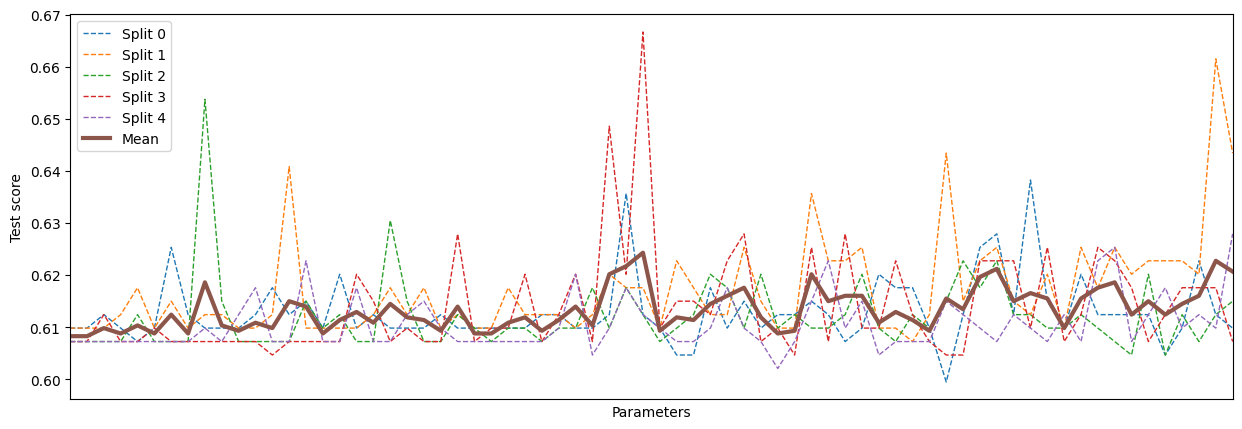

In [ ]:
plt.figure(figsize=(15, 5))
for n in range(n_splits):
    plt.plot(grid_results[f'split{n}_test_score'], label=f'Split {n}', ls='--', lw=1)
plt.plot(grid_results['mean_test_score'], label='Mean', lw=3)
plt.legend()
plt.xlabel('Parameters')
plt.ylabel('Test score')
plt.xlim(0, len(grid_results.index) - 1)
plt.xticks([])

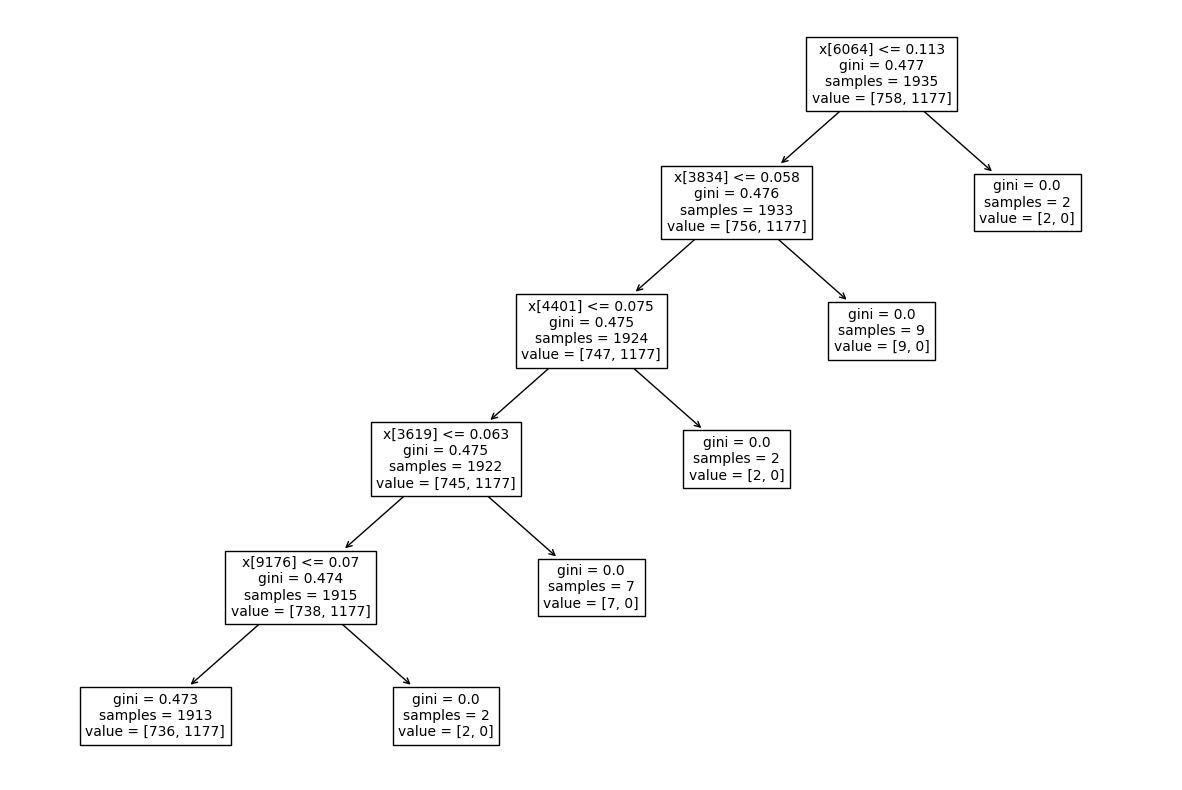

In [ ]:
plt.figure(figsize=(15, 10))
plot_tree(tree_grid.best_estimator_, fontsize=10)
print()

## Testing

In [ ]:
rec_tracks_per_track = 2
max_rec_tracks = 2000
rec_tracks_per_track = min([max_rec_tracks, len(favorites_df['id']) * rec_tracks_per_track]) // len(favorites_df['id'])
print(f"Using {rec_tracks_per_track} test tracks per track")

rec_tracks = []
for i in favorites_df['id']:
    try:
        rec_tracks.extend(spotify.recommendations(seed_tracks=[i], limit=rec_tracks_per_track)['tracks'])
    except:
        break

Using 1 test tracks per track


In [ ]:
rec_track_ids = []
rec_track_names = []
for i in rec_tracks:
    rec_track_ids.append(i['id'])
    rec_track_names.append(i['name'])

rec_features = get_features(spotify, rec_track_ids)
        
rec_playlist_df = pd.DataFrame(rec_features, index=rec_track_names)
rec_playlist_df.drop_duplicates(subset='id', inplace=True)
rec_track_names = rec_playlist_df.index.tolist()
rec_playlist_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
Blurry,0.431,0.9380,3,-4.507,0,0.0542,0.008050,0.000000,0.1380,0.5230,157.462,audio_features,6lSr3iZTC144PKhvbPFzMp,spotify:track:6lSr3iZTC144...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,304000,4
Word Up!,0.580,0.9390,6,-4.425,0,0.0369,0.000027,0.064400,0.3490,0.8040,116.042,audio_features,4D05EjPFWFx3BEQNeB7Vct,spotify:track:4D05EjPFWFx3...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,172667,4
I Don't Mind,0.705,0.8510,0,-5.650,1,0.0675,0.005570,0.067300,0.1190,0.8280,134.217,audio_features,1Ts1YLJ7SbZc1ZRaTWYUcK,spotify:track:1Ts1YLJ7SbZc...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,241960,4
Low Down Dirty,0.489,0.9340,8,-4.355,1,0.0402,0.000045,0.129000,0.2900,0.6680,94.007,audio_features,7Gutanf1Mf2r8ASTlrR5ku,spotify:track:7Gutanf1Mf2r...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,194493,4
Don't Say It's Over,0.382,0.9340,2,-7.384,1,0.0558,0.000095,0.004260,0.3800,0.5230,156.262,audio_features,5nIJXBeZ36Jp70bBzwi6E3,spotify:track:5nIJXBeZ36Jp...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,249600,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Godfather Waltz (Main Title),0.213,0.1070,0,-19.115,0,0.0392,0.974000,0.879000,0.0778,0.1130,62.069,audio_features,3WoSJF85H0qywD4qLp4HDd,spotify:track:3WoSJF85H0qy...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,185467,4
Wolven Storm - English,0.547,0.0818,2,-17.015,0,0.0456,0.955000,0.000002,0.0730,0.5930,150.243,audio_features,0zCqrZ8SEdkzSmhFlRTHlQ,spotify:track:0zCqrZ8SEdkz...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,198400,4
Destiny,0.193,0.1810,9,-16.738,0,0.0463,0.612000,0.949000,0.0360,0.1020,144.153,audio_features,6gdj5rdM4t0z1wrYO48J2x,spotify:track:6gdj5rdM4t0z...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,216733,4
Death Is the Road to Awe (feat. Kronos Quartet),0.187,0.4110,2,-12.058,0,0.0358,0.606000,0.877000,0.0975,0.0763,110.600,audio_features,3RoQX4ou3qYEASsuC7YAWD,spotify:track:3RoQX4ou3qYE...,https://api.spotify.com/v1...,https://api.spotify.com/v1...,505600,4


In [ ]:
testing_df = rec_playlist_df[
    [
        "acousticness", "danceability", "duration_ms", "energy", 
        "instrumentalness",  "key", "liveness", "loudness", "mode", 
        "speechiness", "tempo", "valence"
    ]
]
testing_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
Blurry,0.008050,0.431,304000,0.9380,0.000000,3,0.1380,-4.507,0,0.0542,157.462,0.5230
Word Up!,0.000027,0.580,172667,0.9390,0.064400,6,0.3490,-4.425,0,0.0369,116.042,0.8040
I Don't Mind,0.005570,0.705,241960,0.8510,0.067300,0,0.1190,-5.650,1,0.0675,134.217,0.8280
Low Down Dirty,0.000045,0.489,194493,0.9340,0.129000,8,0.2900,-4.355,1,0.0402,94.007,0.6680
Don't Say It's Over,0.000095,0.382,249600,0.9340,0.004260,2,0.3800,-7.384,1,0.0558,156.262,0.5230
...,...,...,...,...,...,...,...,...,...,...,...,...
The Godfather Waltz (Main Title),0.974000,0.213,185467,0.1070,0.879000,0,0.0778,-19.115,0,0.0392,62.069,0.1130
Wolven Storm - English,0.955000,0.547,198400,0.0818,0.000002,2,0.0730,-17.015,0,0.0456,150.243,0.5930
Destiny,0.612000,0.193,216733,0.1810,0.949000,9,0.0360,-16.738,0,0.0463,144.153,0.1020
Death Is the Road to Awe (feat. Kronos Quartet),0.606000,0.187,505600,0.4110,0.877000,2,0.0975,-12.058,0,0.0358,110.600,0.0763


In [ ]:
estimators = [knc_grid, forest_grid, tree_grid]

testing_df_scaled = StandardScaler().fit_transform(testing_df)

X_test = pca.transform(testing_df_scaled)
X_test_names = v.transform(rec_track_names)

X_test = sparse.csr_matrix(sparse.hstack([X_test, X_test_names]))
y_pred_final = np.array([1] * X_test_names.shape[0])

for estimator in estimators:
    estimator.best_estimator_.fit(X_train, y_train)
    y_pred = estimator.best_estimator_.predict(X_test)
    
    y_pred_final = y_pred_final * y_pred
    print("Number of disliked tracks by model: ", sum(y_pred == 0))
    print("Number of disliked tracks: ", sum(y_pred_final == 0))
    print("Number of liked tracks: ", sum(y_pred_final == 1))
    print()

Number of disliked tracks by model:  498
Number of disliked tracks:  498
Number of liked tracks:  1354

Number of disliked tracks by model:  1
Number of disliked tracks:  498
Number of liked tracks:  1354

Number of disliked tracks by model:  0
Number of disliked tracks:  498
Number of liked tracks:  1354



In [ ]:
final_tracks = testing_df[y_pred_final.astype(bool)]
final_tracks

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
Word Up!,0.000027,0.580,172667,0.9390,0.064400,6,0.3490,-4.425,0,0.0369,116.042,0.804
I Don't Mind,0.005570,0.705,241960,0.8510,0.067300,0,0.1190,-5.650,1,0.0675,134.217,0.828
Low Down Dirty,0.000045,0.489,194493,0.9340,0.129000,8,0.2900,-4.355,1,0.0402,94.007,0.668
Don't Say It's Over,0.000095,0.382,249600,0.9340,0.004260,2,0.3800,-7.384,1,0.0558,156.262,0.523
Where the Story Ends,0.020700,0.371,237227,0.6000,0.000000,1,0.1020,-7.393,1,0.0338,139.265,0.214
...,...,...,...,...,...,...,...,...,...,...,...,...
Joker's Song,0.817000,0.448,214640,0.4300,0.000000,11,0.1320,-8.357,0,0.0644,169.875,0.624
For Honor! For Toussaint!,0.103000,0.629,124500,0.8170,0.026200,9,0.3340,-9.167,0,0.0428,90.027,0.466
Òran an Ròin,0.885000,0.363,155108,0.1200,0.000000,3,0.1810,-12.573,1,0.0367,136.238,0.281
Hymn To Red October (Main Title),0.973000,0.425,306467,0.0578,0.000003,7,0.0829,-19.859,0,0.0265,81.154,0.206
